<a href="https://colab.research.google.com/github/jasminjahanpuspo/Bengali_Taka/blob/main/Bangla_Paper_Currency/BPC_AMHAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**<font color='yellow'>Model Name: InceptionV3 with CBAM+ECA</font>**


# Step 1: Setup Environment

##### 🔹 Mount Google Drive
*   Access datasets stored in your Google Drive.  
*   After running this cell, you'll be prompted to authorize access.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### 🔹 Import Required Libraries
*   Load all necessary libraries for image processing, data handling, and visualization.
*   Load TensorFlow, Keras, and layers for building CNN models.

In [2]:
# ============================================================
#  Libraries for Data Handling
# ============================================================
import os                      # File and directory operations
import glob as gb              # File pattern matching (e.g., get all image paths)
import numpy as np             # Numerical operations and arrays
import pandas as pd            # Data manipulation and analysis

# ============================================================
#  Libraries for Image Processing
# ============================================================
import cv2                     # OpenCV for image reading and preprocessing
from PIL import Image          # Image loading and manipulation

# ============================================================
#  Libraries for Visualization
# ============================================================
import matplotlib.pyplot as plt # Plotting graphs and images
import seaborn as sns           # Advanced visualizations (e.g., heatmaps)
%matplotlib inline
import matplotlib

# ============================================================
#  Utilities and Helpers
# ============================================================
import random                  # For random sampling and augmentations
import math                    # Mathematical operations
import time                    # Measure training time and performance

In [3]:
# ============================================================
# TensorFlow & Keras Core Libraries
# ============================================================
import tensorflow as tf                       # Core TensorFlow library
from tensorflow import keras                  # High-level API for deep learning
from tensorflow.keras import layers, models   # Layers and model-building utilities

# ============================================================
# Dataset Utilities
# ============================================================
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
# Load and preprocess image datasets from directory structures

# ============================================================
# Layers for CNN Architectures
# ============================================================
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten,
    Conv2D, MaxPool2D, LeakyReLU
)
from tensorflow.keras import layers, backend as K
from tensorflow.keras.optimizers import Adam

In [4]:
from datetime import datetime
from zoneinfo import ZoneInfo

local_time = datetime.now(ZoneInfo("Asia/Dhaka"))
print("Date and Time:", local_time.strftime("%d-%b-%Y %I:%M %p"))

Date and Time: 29-Oct-2025 11:06 AM


# Step 2: Prepare Dataset

##### 🔹Create TensorFlow Datasets


*   Load images from the directories into TensorFlow datasets for training, validation, and testing.  
*   You can adjust `image_size` and `batch_size` as needed.



In [5]:
## Define the directories for training, testing, and validation
train_directory = '/content/drive/MyDrive/Bengali_Taka/BP/BP_F/split/train'
test_directory = '/content/drive/MyDrive/Bengali_Taka/BP/BP_F/split/test'
valid_directory = '/content/drive/MyDrive/Bengali_Taka/BP/BP_F/split/val'

In [6]:
IMG_SIZE = (299, 299)  # define resolution (299,299) /(224,224)
BATCH_SIZE = 128       # varies from dataset to datset prefferable 128/68/32

In [7]:
# Create TensorFlow datasets for training, testing, and validation
#you can customize parameters as per dataset
train_dataset = image_dataset_from_directory(
    train_directory,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb',
    seed=42
)

test_dataset = image_dataset_from_directory(
    test_directory,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb',
    seed=42
)

valid_dataset = image_dataset_from_directory(
    valid_directory,
    shuffle=True,
    labels='inferred',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode='rgb',
    seed=42
)

Found 2520 files belonging to 9 classes.
Found 540 files belonging to 9 classes.
Found 540 files belonging to 9 classes.


In [8]:
# Automatically detect number of classes from dataset
class_names = train_dataset.class_names  # works with image_dataset_from_directory
n_classes = len(class_names)

print("Detected Classes:", class_names)
print("Number of Classes:", n_classes)

Detected Classes: ['10', '100', '1000', '2', '20', '200', '5', '50', '500']
Number of Classes: 9


#**<font color='red'>Proposed Model</font>**


## Step 3.1: Model Training

##### 🔗 AMHAN Model



In [9]:
# ---------------------------
# 2) Attention modules (CBAM + ECA on vector)
# ---------------------------
class ChannelAttention(layers.Layer):
    def __init__(self, channels, ratio=8, **kwargs):
        super().__init__(**kwargs)
        self.channels = channels
        self.ratio = ratio
        self.avg_pool = layers.GlobalAveragePooling2D()
        self.max_pool = layers.GlobalMaxPooling2D()
        self.fc1 = layers.Dense(max(1, channels // ratio), activation='relu', kernel_initializer='he_normal')
        self.fc2 = layers.Dense(channels, kernel_initializer='he_normal')

    def call(self, inputs):
        a = self.avg_pool(inputs)   # (B, C)
        m = self.max_pool(inputs)   # (B, C)
        a_out = self.fc2(self.fc1(a))
        m_out = self.fc2(self.fc1(m))
        attn = tf.nn.sigmoid(a_out + m_out)   # (B, C)
        attn = tf.reshape(attn, (-1, 1, 1, self.channels))
        return inputs * attn

class SpatialAttention(layers.Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super().__init__(**kwargs)
        self.conv = layers.Conv2D(1, kernel_size, padding='same', activation='sigmoid', kernel_initializer='he_normal')

    def call(self, inputs):
        avg_out = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_out = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = tf.concat([avg_out, max_out], axis=-1)
        attn = self.conv(concat)
        return inputs * attn

class CBAM(layers.Layer):
    def __init__(self, channels, ratio=8, kernel_size=7, **kwargs):
        super().__init__(**kwargs)
        self.ca = ChannelAttention(channels, ratio)
        self.sa = SpatialAttention(kernel_size)

    def call(self, inputs):
        x = self.ca(inputs)
        x = self.sa(x)
        return x

# ECA adapted to 1D channel vector (works on pooled vectors)
class ECABlockVector(layers.Layer):
    def __init__(self, k_size=3, **kwargs):
        super().__init__(**kwargs)
        self.k_size = k_size
        # will build conv1d in build() when channels are known

    def build(self, input_shape):
        # input_shape: (B, C)
        channels = int(input_shape[-1])
        # conv1d expects (B, C, 1)
        self.conv1d = layers.Conv1D(1, kernel_size=self.k_size, padding='same', use_bias=False,
                                    kernel_initializer='he_normal')
        self.channels = channels
        super().build(input_shape)

    def call(self, inputs):
        # inputs: (B, C)
        x = tf.expand_dims(inputs, axis=-1)     # (B, C, 1)
        x = self.conv1d(x)                      # (B, C, 1)
        x = tf.nn.sigmoid(x)                    # (B, C, 1)
        x = tf.squeeze(x, axis=-1)              # (B, C)
        return inputs * x                       # channel-wise scaling on vector


In [10]:
# ---------------------------
# 3) Model builder - vector fusion (safe)
# ---------------------------
def choose_inception_layers(model, num_stages=2):
    # pick 'mixed' layers if present (safe automatic)
    mixed = [l.name for l in model.layers if 'mixed' in l.name]
    if len(mixed) >= num_stages:
        # choose evenly spaced
        picks = []
        step = len(mixed) / (num_stages + 1)
        for i in range(num_stages):
            idx = int((i+1)*step) - 1
            idx = max(0, min(idx, len(mixed)-1))
            picks.append(mixed[idx])
        return picks
    # fallback: choose two deeper convs
    return [model.layers[int(len(model.layers)*0.5)].name,
            model.layers[int(len(model.layers)*0.75)].name][:num_stages]


In [11]:

def create_amhan_vector_fusion(image_shape=(299,299,3), num_classes=n_classes,
                               base_freeze_until=249, cbam_ratio=8,
                               eca_k=3, num_stages=2, post_fc_units=512):
    # Base InceptionV3
    base = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=image_shape)
    base.trainable = True
    for layer in base.layers[:base_freeze_until]:
        layer.trainable = False

    # choose intermediate stage layer names
    chosen = choose_inception_layers(base, num_stages=num_stages)
    # outputs: intermediates + final
    outputs = [base.get_layer(name).output for name in chosen] + [base.output]
    feat_model = models.Model(inputs=base.input, outputs=outputs, name='inception_feat_extractor')

    # Model input
    inputs = layers.Input(shape=image_shape)
    x_in = tf.keras.applications.inception_v3.preprocess_input(inputs)
    feats = feat_model(x_in)   # list of tensors

    # Ensure list
    if not isinstance(feats, (list, tuple)):
        feats = [feats]

    # Apply CBAM to each stage then GAP -> (B, C_stage)
    pooled_vectors = []
    for f in feats:
        C = int(f.shape[-1])
        att = CBAM(channels=C, ratio=cbam_ratio)(f)
        vec = layers.GlobalAveragePooling2D()(att)   # (B, C)
        pooled_vectors.append(vec)

    # Now we have list of vectors (B, C1), (B, C2), ..., (B, C_final)
    # Concatenate them into a single vector
    fused_vector = layers.Concatenate(axis=-1)(pooled_vectors)  # (B, sum(Ci))

    # Optionally apply ECA on vector
    x = ECABlockVector(k_size=eca_k)(fused_vector)               # (B, channels_sum)

    # Fusion MLP
    x = layers.Dense(post_fc_units, activation='relu', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name='AMHAN')
    return model


##### 🔹 Instantiate the model
*   Initialize the full model with custom layers.

In [25]:
# -----------------------------
base_learning_rate = 0.0001
model = create_amhan_vector_fusion(image_shape=IMG_SIZE + (3,),
                                   num_classes=n_classes,
                                   base_freeze_until=249,
                                   cbam_ratio=8,
                                   eca_k=3,
                                   num_stages=2,
                                   post_fc_units=512)

##### 🔹 Build and Compile Model

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


##### 🔹 Model Visualization

* Display the model structure in both graphical and tabular formats to verify architecture before training.

In [27]:
model.summary()

Model: "AMHAN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_4       │ (None, 299, 299,  │          0 │ input_layer_9[0]… │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_4          │ (None, 299, 299,  │          0 │ true_divide_4[0]… │
│ (Subtract)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_feat_ext… │ [(None, 17, 17,   │ 21,802,784 │ subtract_4[0][0]  │
│ (Functional)        │ 768), (None, 17,  │            │                   │
│                     │ 17, 768), (None,  │            │                   │
│                     │ 8, 8, 2048)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cbam_9 (CBAM)       │ (None, 17, 17,    │    148,419 │ inception_feat_e… │
│                     │ 768)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cbam_10 (CBAM)      │ (None, 17, 17,    │    148,419 │ inception_feat_e… │
│                     │ 768)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cbam_11 (CBAM)      │ (None, 8, 8,      │  1,050,979 │ inception_feat_e… │
│                     │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 768)       │          0 │ cbam_9[0][0]      │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 768)       │          0 │ cbam_10[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ cbam_11[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 3584)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ eca_block_vector_3  │ (None, 3584)      │          3 │ concatenate_11[0… │
│ (ECABlockVector)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 512)       │  1,835,520 │ eca_block_vector… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_32[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 9)         │      4,617 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,992,789 (95.34 MB)

 Trainable params: 14,303,861 (54.56 MB)

 Non-trainable params: 10,688,928 (40.78 MB)

In [28]:
model = create_amhan_vector_fusion()
model.save("AMHAN.keras")

!pip install netron
import netron
netron.start("AMHAN.keras")


('localhost', 18688)

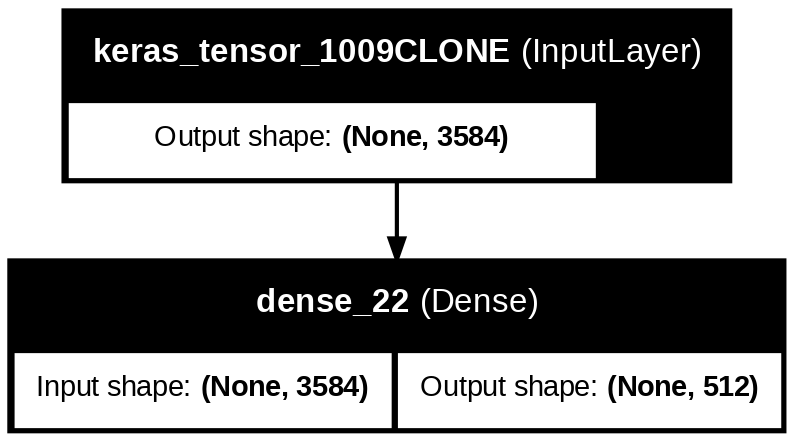

In [16]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model

# Assuming you already built the full model
model = create_amhan_vector_fusion(image_shape=(224,224,3), num_classes=n_classes)

# Extract only the hybrid attention portion
hybrid_input = model.get_layer(index=-4).input   # Input before GlobalAveragePooling
hybrid_output = model.get_layer(index=-4).output # Output after HybridAttention

# Create a sub-model for visualization
hybrid_part = Model(inputs=hybrid_input, outputs=hybrid_output, name="AMHAN")

# Plot and save only the Hybrid Attention architecture
plot_model(
    hybrid_part,
    to_file='AMHAN.png',
    show_shapes=True,
    show_layer_names=True,
    dpi=150
)


In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras import layers

# Input tensor same as full model
inputs = layers.Input(shape=(299, 299, 3))

# Use Inception preprocessing
x_in = tf.keras.applications.inception_v3.preprocess_input(inputs)

# Mimic the proposed portion of the AMHAN model
# Example: single feature vector input (you can adjust the shape)
feat_input = layers.Input(shape=(8*2048,))  # example fused vector size
x = layers.Dense(512, activation='relu', kernel_initializer='he_normal')(feat_input)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(n_classes, activation='softmax')(x)

# Sub-model for visualization
amhan_proposed_model = Model(inputs=feat_input, outputs=outputs, name="AMHAN_Proposed")


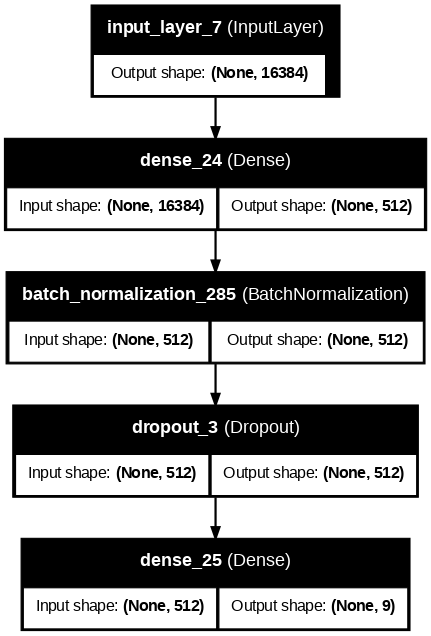

In [18]:
from tensorflow.keras.utils import plot_model

plot_model(
    amhan_proposed_model,
    to_file='amhan_proposed_block.png',
    show_shapes=True,
    show_layer_names=True,
    dpi=80
)

##### 🔹 Load / Set Model Weights
Load pre-trained weights or initialize custom weights for the CNN + CBAM model.


In [ ]:
class_counts = []
for i in range(len(train_dataset.class_names)):
    class_counts.append(sum(1 for _, label in train_dataset.unbatch().as_numpy_iterator() if label == i))

Dataset = class_counts  # now your class weights will adapt automatically

In [ ]:
# Assuming you already have Dataset as a list of samples per class
# or you can compute from train_dataset using:
# class_counts = [sum(1 for _, label in train_dataset.unbatch().as_numpy_iterator() if label==i) for i in range(n_classes)]

total = sum(Dataset)        # total number of images
class_weight = {}

for i, count in enumerate(Dataset):
    class_weight[i] = (1 / count) * (total / len(Dataset))

# Print class weights
for i, w in class_weight.items():
    print(f"Weight for class {i}: {w:.2f}")


Weight for class 0: 1.00
Weight for class 1: 1.00
Weight for class 2: 1.00


##### 🔹 Model Checkpoint & Save
Save the best model during training using **checkpoints**, and optionally save the final trained model.


In [29]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
# ===== Callbacks =====
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

##### 🔹 Train the Model
Train the Hybrid attemtion mechanism with CNN model using the training dataset, validate on the validation dataset, and store the training history.


In [31]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [32]:
# ===== Train Model =====
print("🟢 Training AMHAN model...")
start_time = time.time()

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=15,                 # adjust as needed
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=2
)

end_time = time.time()
print(f"Training completed in {(end_time - start_time)/60:.2f} minutes")

🟢 Training AMHAN model...
Epoch 1/15

Epoch 1: val_loss improved from inf to 1.44222, saving model to best_model.keras
20/20 - 896s - 45s/step - accuracy: 0.8817 - loss: 0.3732 - val_accuracy: 0.7907 - val_loss: 1.4422 - learning_rate: 1.0000e-03
Epoch 2/15

Epoch 2: val_loss improved from 1.44222 to 1.13458, saving model to best_model.keras
20/20 - 17s - 835ms/step - accuracy: 0.9968 - loss: 0.0163 - val_accuracy: 0.8963 - val_loss: 1.1346 - learning_rate: 1.0000e-03
Epoch 3/15

Epoch 3: val_loss improved from 1.13458 to 0.89354, saving model to best_model.keras
20/20 - 16s - 823ms/step - accuracy: 0.9980 - loss: 0.0091 - val_accuracy: 0.9093 - val_loss: 0.8935 - learning_rate: 1.0000e-03
Epoch 4/15

Epoch 4: val_loss improved from 0.89354 to 0.65601, saving model to best_model.keras
20/20 - 17s - 852ms/step - accuracy: 0.9984 - loss: 0.0063 - val_accuracy: 0.9481 - val_loss: 0.6560 - learning_rate: 1.0000e-03
Epoch 5/15

Epoch 5: val_loss improved from 0.65601 to 0.55486, saving mode

##### 🔹 Test the Model
Evaluate the trained model on the test dataset.

In [33]:
model.evaluate(test_dataset , verbose = 1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 142s 27s/step - accuracy: 0.9957 - loss: 0.0378


[0.04008001461625099, 0.9944444298744202]

## Step 4.1: Results & Visualizations


##### 🔹 Actual vs Predicted Classes

*  Visualize the model’s predictions compared to true labels on the test dataset.
*   Collect **one example per class** from `test_dataset`.




1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


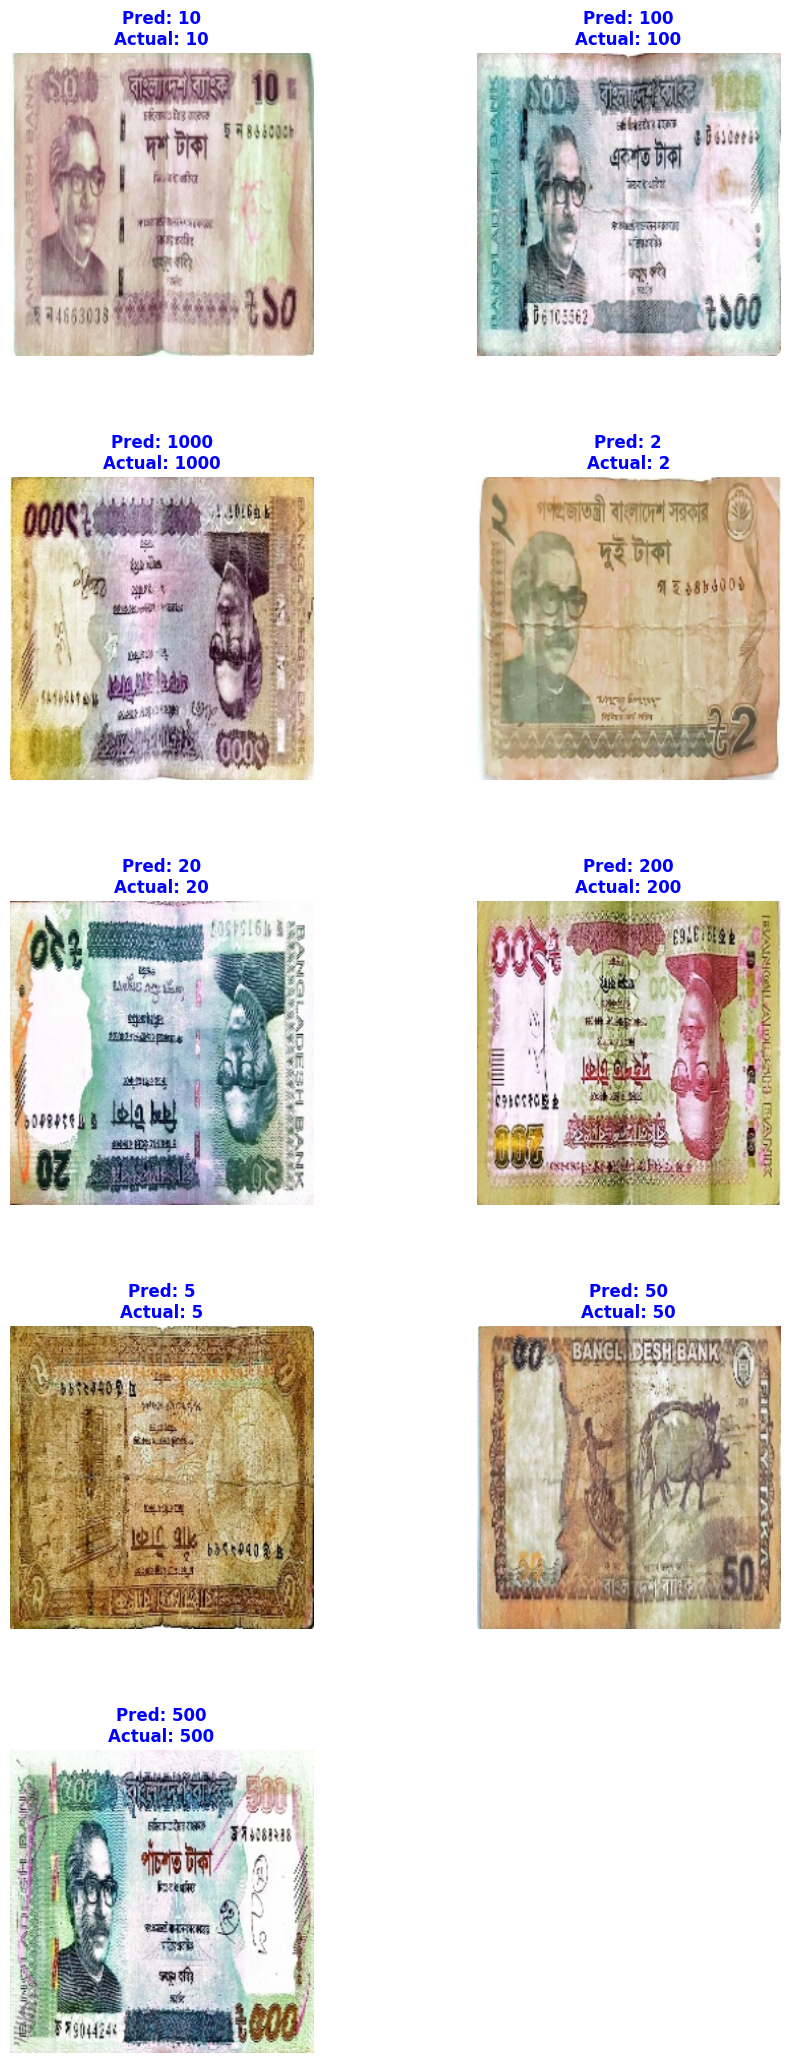

In [34]:
examples = {}
for images, labels in test_dataset.unbatch().take(1000):  # take enough to find all classes
    class_idx = labels.numpy()
    if class_idx not in examples:
        examples[class_idx] = images
    if len(examples) == n_classes:
        break

# Plotting
cols = 2  # number of columns
rows = math.ceil(n_classes / cols)
plt.figure(figsize=(cols * 5, rows * 5))

for i, class_idx in enumerate(sorted(examples.keys())):
    img = examples[class_idx].numpy().astype("uint8")
    img_exp = tf.expand_dims(img, 0)  # expand batch dim
    predict = model.predict(img_exp)
    predicted = class_names[np.argmax(predict)]
    actual = class_names[class_idx]

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis("off")
    color = 'blue' if predicted == actual else 'red'
    plt.title(f"Pred: {predicted}\nActual: {actual}", fontsize=12, fontweight='bold', color=color)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9,
                        top=0.9, wspace=0.4, hspace=0.4)

plt.show()

##### 🔹 Actual vs Predicted Images

*   Display sample images from the test set with their **true labels and model predictions** for qualitative evaluation.
*   Show **three images per class** for qualitative evaluation.


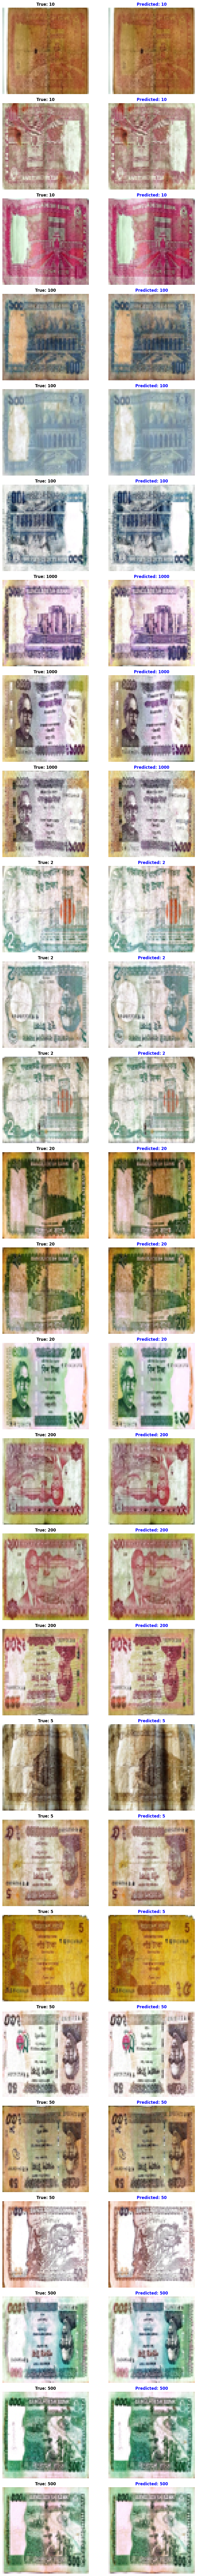

In [35]:
# Function to load multiple random images per class
def load_images_per_class(folder, num_images_per_class=3):
    images = []
    labels = []
    class_names = []

    for class_idx, subfolder in enumerate(sorted(os.listdir(folder))):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            class_names.append(subfolder)
            image_files = os.listdir(subfolder_path)
            selected_files = random.sample(image_files, min(num_images_per_class, len(image_files)))
            for image_file in selected_files:
                img_path = os.path.join(subfolder_path, image_file)
                img = Image.open(img_path).convert('RGB')
                img = img.resize((64, 64))
                images.append(np.array(img)/255.0)
                labels.append(class_idx)

    return np.array(images), np.array(labels), class_names

# Path to your test folder
test_folder = test_directory

# Load images: change num_images_per_class as needed
num_images_per_class = 3
images, labels, class_names = load_images_per_class(test_folder, num_images_per_class=num_images_per_class)

# Example predicted labels (replace with your model predictions)
predicted_labels = labels.copy()  # For demo, assume correct predictions

# Automatically calculate subplot grid
total_images = len(images)
cols = 2  # Original + Predicted
rows = total_images  # Each image gets a row

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))

if rows == 1:  # Special case if only 1 image
    axes = np.expand_dims(axes, axis=0)

for i in range(total_images):
    img = images[i]
    true_label = class_names[labels[i]]
    predicted_label = class_names[predicted_labels[i]]

    # Original
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'True: {true_label}', fontsize=12, fontweight='bold')
    axes[i, 0].axis('off')

    # Predicted
    axes[i, 1].imshow(img)
    color = 'blue' if true_label == predicted_label else 'red'
    axes[i, 1].set_title(f'Predicted: {predicted_label}', fontsize=12, fontweight='bold', color=color)
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


##### 🔹 Label Binarization & Classification Metrics
Binarize class labels and evaluate model performance using metrics like **accuracy, precision, recall, and F1-score**.


In [36]:
from sklearn.preprocessing import label_binarize

# Initialize empty lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the validation dataset and make predictions
for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    true_labels.extend(labels.numpy())

# Binarize the true and predicted labels
true_labels_bin = label_binarize(true_labels, classes=np.unique(true_labels))
predicted_labels_bin = label_binarize(predicted_labels, classes=np.unique(predicted_labels))

4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 122ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


##### 🔹 Classification Report

Provides precision, recall, F1-score, and support for each class to summarize model performance.


In [37]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the classification report
print(report)

              precision    recall  f1-score   support

          10       1.00      1.00      1.00        60
         100       1.00      1.00      1.00        60
        1000       1.00      1.00      1.00        60
           2       1.00      0.98      0.99        60
          20       1.00      0.98      0.99        60
         200       1.00      1.00      1.00        60
           5       0.95      1.00      0.98        60
          50       1.00      0.98      0.99        60
         500       1.00      1.00      1.00        60

    accuracy                           0.99       540
   macro avg       0.99      0.99      0.99       540
weighted avg       0.99      0.99      0.99       540



##### 🔹 Confusion Matrix
Visualize the **confusion matrix** to assess class-wise prediction performance.

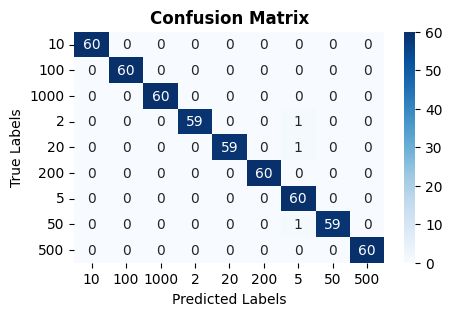

In [38]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix', fontweight='bold')
plt.show()

##### 📈 Training Accuracy & Loss
Visualize the model's **training and validation accuracy and loss** over epochs to assess learning and overfitting.

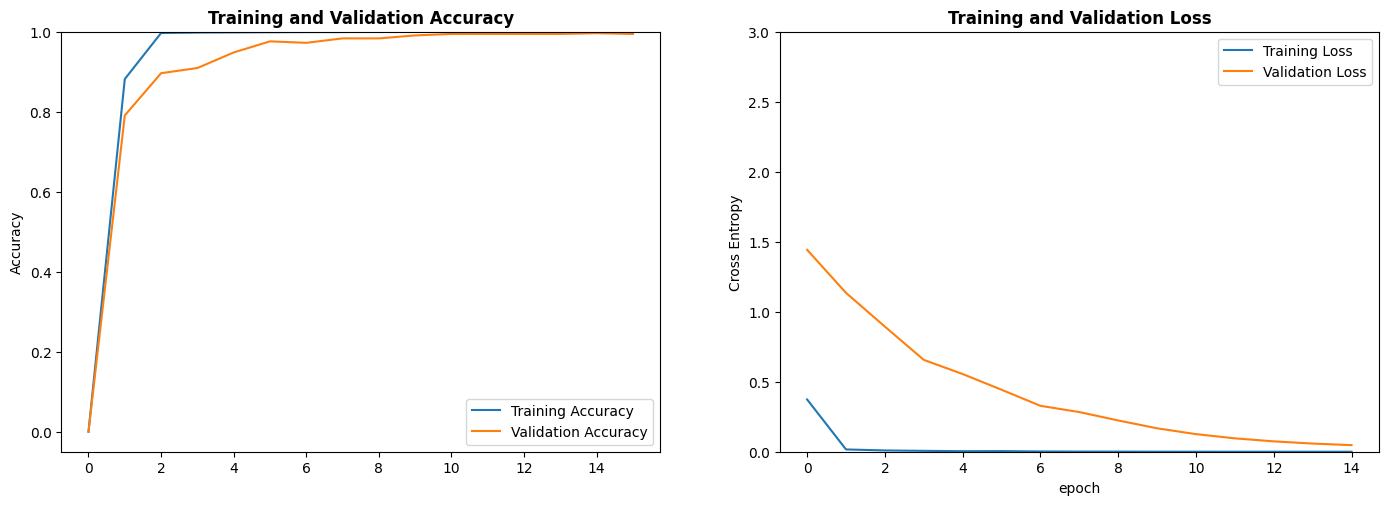

In [39]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(17, 12))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy', fontweight='bold')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss', fontweight='bold')
plt.xlabel('epoch')
plt.show()

##### 📈 ROC curve
*   Plot the **ROC curve** to evaluate model performance.
*  **One-vs-Rest** for multiclass and
 **One-vs-One** for binary classification.

In [40]:
from sklearn.metrics import roc_curve, auc

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in test_dataset:     # or valid_dataset if you want
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Shape of predictions:", y_pred.shape)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
Shape of predictions: (540, 9)


In [41]:
# Binarize labels for multiclass ROC
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

In [42]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


/tmp/ipython-input-860881180.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', n_classes)  # 'tab20' or 'tab10', n_classes colors


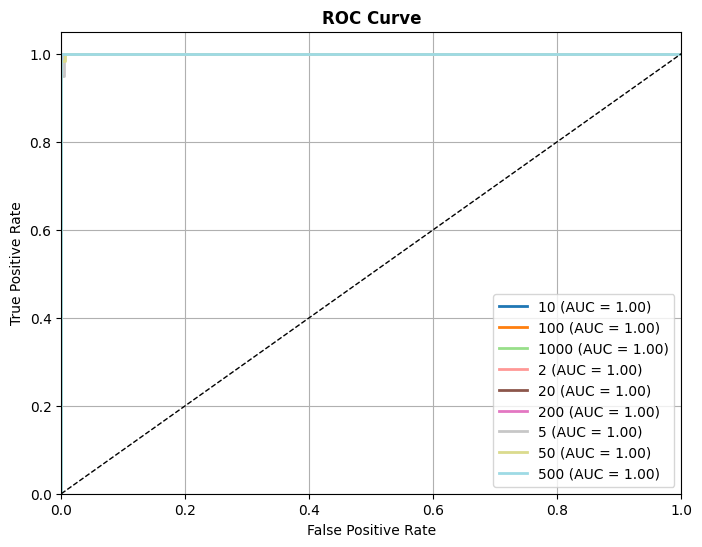

In [43]:
import matplotlib.cm as cm

plt.figure(figsize=(8, 6))

# Automatically generate colors
colors = cm.get_cmap('tab20', n_classes)  # 'tab20' or 'tab10', n_classes colors

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve', fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


##### 🔹 Cohen's Kappa
Measure agreement between predicted and true labels beyond chance.

In [44]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(true_labels, predicted_labels)
print(f'Cohen\'s Kappa: {kappa:.4f}')

Cohen's Kappa: 0.9938


##### 🔹 Matthews Correlation Coefficient (MCC)
Assess overall classification quality considering all confusion matrix terms.

In [45]:
from sklearn.metrics import matthews_corrcoef

# Assuming true_labels and predicted_labels are multiclass labels
mcc_values = [matthews_corrcoef(true_labels == i, predicted_labels == i) for i in np.unique(true_labels)]

average_mcc = np.mean(mcc_values)
print(f'Average Matthews Correlation Coefficient for Multiclass: {average_mcc:.4f}')

Average Matthews Correlation Coefficient for Multiclass: 0.9938


##### 🔹 Right vs Wrong Classifier
Visualize and analyze **correctly and incorrectly classified samples** to understand model performance.

In [46]:
# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Calculate total right and wrong predictions
total_right = sum(1 for true, pred in zip(true_labels, predicted_labels) if true == pred)
total_wrong = sum(1 for true, pred in zip(true_labels, predicted_labels) if true != pred)
total_samples = len(true_labels)

print("Total Right Predictions:", total_right)
print("Total Wrong Predictions:", total_wrong)

# Calculate percentages
right_percentage = (total_right / total_samples) * 100
wrong_percentage = (total_wrong / total_samples) * 100

# Data for the bar plot
labels = ['Right', 'Wrong']
percentages = [right_percentage, wrong_percentage]

Total Right Predictions: 537
Total Wrong Predictions: 3


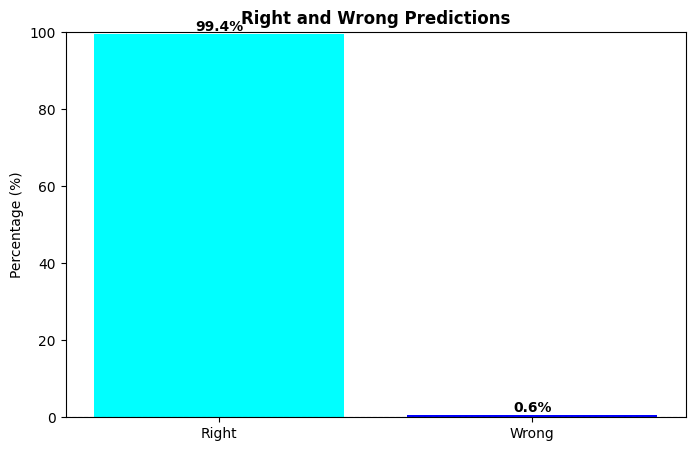

In [47]:
# Create the bar plot
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, percentages, color=['cyan', 'blue'])

# Add percentage labels above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}%',
             ha='center', fontweight='bold', va='bottom')  # va: vertical alignment

# Add titles and labels
plt.title('Right and Wrong Predictions', fontweight='bold')
plt.ylabel('Percentage (%)')
plt.ylim(0, 100)  # Set y-axis limit to 100%
plt.axhline(0, color='grey', linewidth=0.8, linestyle='--')  # Optional: Add a horizontal line at y=0

# Show the plot
plt.show()

##### 🔹 Sensitivity & Specificity
Evaluate each class's **sensitivity (recall)** and **specificity** based on true positives and true negatives


Overall Sensitivity (Recall): 0.994
Overall Specificity: 0.999


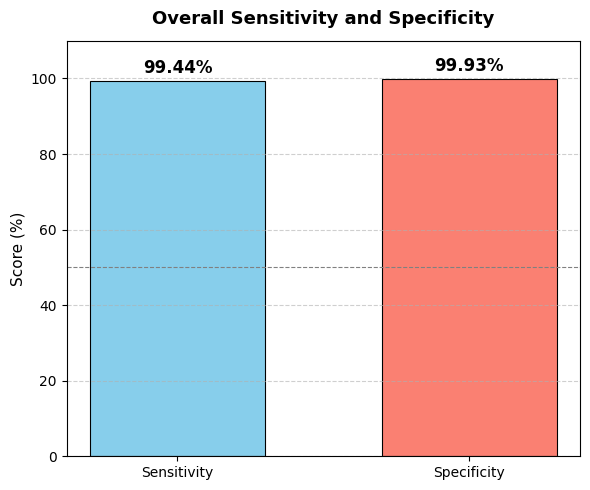

In [48]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# --- Compute Sensitivity & Specificity ---
cm = confusion_matrix(true_labels, predicted_labels)
n_classes = cm.shape[0]

# Sensitivity (macro average): TP / (TP + FN)
sensitivity_per_class = np.diag(cm) / np.sum(cm, axis=1)
sensitivity = np.nanmean(sensitivity_per_class)

# Specificity (macro average): TN / (TN + FP)
specificity_list = []
for i in range(n_classes):
    tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
    fp = np.sum(np.delete(cm, i, axis=0)[:, i])
    specificity_list.append(tn / (tn + fp) if (tn + fp) > 0 else np.nan)
specificity = np.nanmean(specificity_list)

print(f"Overall Sensitivity (Recall): {sensitivity:.3f}")
print(f"Overall Specificity: {specificity:.3f}")

# --- Plotting ---
metrics = ['Sensitivity', 'Specificity']
values = [sensitivity * 100, specificity * 100]  # Convert to percentage

plt.figure(figsize=(6, 5))
bars = plt.bar(metrics, values,
               color=['skyblue', 'salmon'],
               width=0.6, edgecolor='black', linewidth=0.8)

# Add percentage labels on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1.0, f'{yval:.2f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Overall Sensitivity and Specificity', fontsize=13, fontweight='bold', pad=12)
plt.ylabel('Score (%)', fontsize=11)
plt.ylim(0, 110)  # Add headroom for labels
plt.axhline(y=50, color='grey', linestyle='--', linewidth=0.8)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


##### 🔹 Jaccard Index & Dice Score
* Measure overlap between predicted and true classes using **Jaccard Index (IoU)** and **Dice Score**.


Overall Jaccard Index: 0.989
Overall Dice Score: 0.994


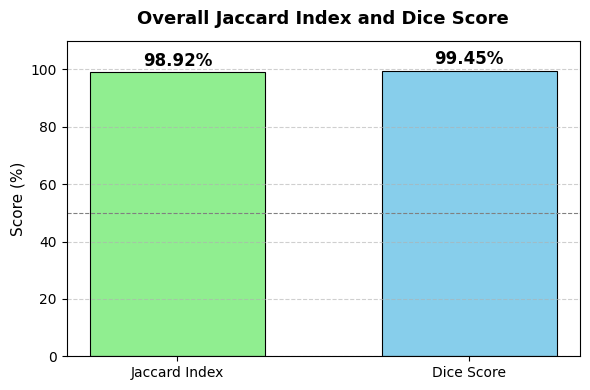

In [49]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# --- Compute confusion matrix and scores ---
cm = confusion_matrix(true_labels, predicted_labels)
n_classes = cm.shape[0]

jaccard_per_class = []
dice_per_class = []

for i in range(n_classes):
    tp = cm[i, i]
    fp = np.sum(cm[:, i]) - tp
    fn = np.sum(cm[i, :]) - tp

    # Jaccard Index
    jaccard = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else np.nan
    jaccard_per_class.append(jaccard)

    # Dice Score
    dice = 2*tp / (2*tp + fp + fn) if (2*tp + fp + fn) > 0 else np.nan
    dice_per_class.append(dice)

# Macro-average (overall)
jaccard_index = np.nanmean(jaccard_per_class)
dice_score = np.nanmean(dice_per_class)

print(f"Overall Jaccard Index: {jaccard_index:.3f}")
print(f"Overall Dice Score: {dice_score:.3f}")

# --- Plotting ---
metrics = ['Jaccard Index', 'Dice Score']
values = [jaccard_index * 100, dice_score * 100]  # convert to %

plt.figure(figsize=(6, 4))
bars = plt.bar(metrics, values,
               color=['lightgreen', 'skyblue'],
               width=0.6, edgecolor='black', linewidth=0.8)

# Add percentage labels on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1.0, f'{yval:.2f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Overall Jaccard Index and Dice Score', fontsize=13, fontweight='bold', pad=12)
plt.ylabel('Score (%)', fontsize=11)
plt.ylim(0, 110)  # headroom for labels
plt.axhline(y=50, color='grey', linestyle='--', linewidth=0.8)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


##### 🔹 Model Evaluation Metrics
Summarize the model's performance using multiple metrics: **Accuracy**, **Precision**, **Recall (Sensitivity)**, **F1 Score**, **Negative Predictive Value (NPV)**, **AUC-ROC**

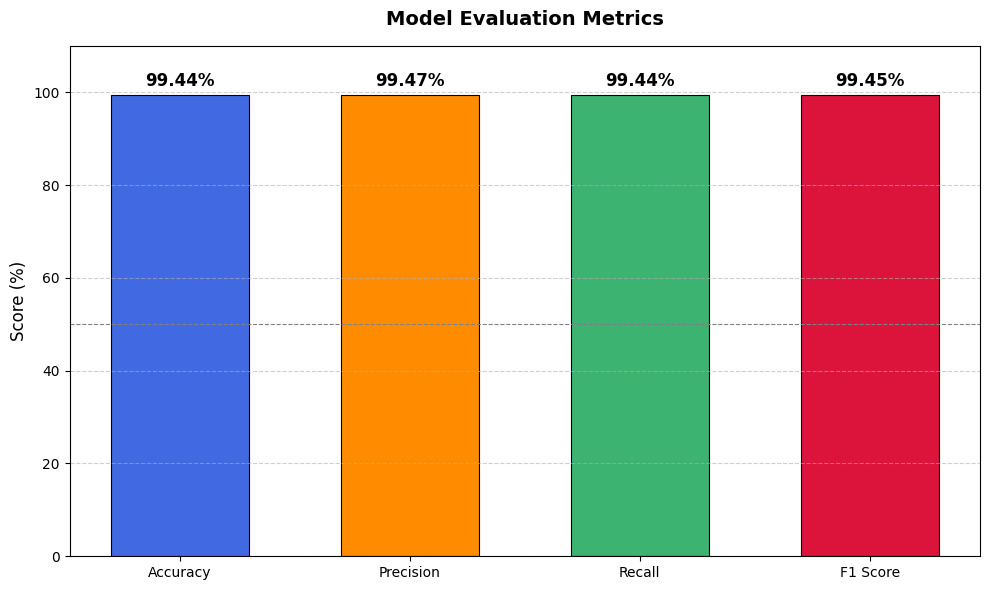

In [50]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# ----- Metric Computation -----
n_classes = len(np.unique(true_labels))

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

# Binary: compute NPV and AUC
if n_classes == 2:
    cm = confusion_matrix(true_labels, predicted_labels)
    tn, fp, fn, tp = cm.ravel()
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    auc = roc_auc_score(true_labels, predicted_labels)
else:
    npv = np.nan
    auc = np.nan

metrics = {
    'Accuracy': accuracy * 100,
    'Precision': precision * 100,
    'Recall': recall * 100,
    'F1 Score': f1 * 100,
    'NPV': npv * 100 if not np.isnan(npv) else np.nan,
    'AUC-ROC': auc * 100 if not np.isnan(auc) else np.nan
}

# ----- Plotting -----
plt.figure(figsize=(10, 6))

bars = plt.bar(metrics.keys(), metrics.values(),
               color=['royalblue', 'darkorange', 'mediumseagreen', 'crimson', 'orchid', 'deepskyblue'],
               width=0.6, edgecolor='black', linewidth=0.8)

# Add value labels
for bar in bars:
    yval = bar.get_height()
    if not np.isnan(yval):  # skip NaNs
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1.0, f'{yval:.2f}%',  # show % with 2 decimals
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Model Evaluation Metrics', fontsize=14, fontweight='bold', pad=15)
plt.ylabel('Score (%)', fontsize=12)
plt.ylim(0, 110)  # allow space above 100%
plt.axhline(y=50, color='grey', linestyle='--', linewidth=0.8)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [51]:
# Print metric values
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Accuracy: 99.4444
Precision: 99.4709
Recall: 99.4444
F1 Score: 99.4489
NPV: nan
AUC-ROC: nan


##### 🔹 PR-AUC (Precision-Recall AUC)
Evaluate model performance using the **area under the Precision-Recall curve**, especially useful for imbalanced datasets.

In [52]:
from sklearn.metrics import precision_recall_curve, auc

# Get true labels and predicted probabilities
y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
y_pred_probs = model.predict(test_dataset)

# Handle binary or multiclass
if y_pred_probs.shape[1] == 2:  # binary
    precision, recall, _ = precision_recall_curve(y_true, y_pred_probs[:, 1])
    pr_auc = auc(recall, precision)
else:  # multiclass
    pr_auc = {}
    from sklearn.preprocessing import label_binarize
    y_true_bin = label_binarize(y_true, classes=range(y_pred_probs.shape[1]))
    for i in range(y_pred_probs.shape[1]):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
        pr_auc[i] = auc(recall, precision)

print("PR-AUC:", pr_auc)


5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step
PR-AUC: {0: np.float64(0.11290950841146347), 1: np.float64(0.11763614321415486), 2: np.float64(0.13517241559258922), 3: np.float64(0.11270333070557619), 4: np.float64(0.1265892621077095), 5: np.float64(0.10779513661249138), 6: np.float64(0.08826277636102511), 7: np.float64(0.10355073605403134), 8: np.float64(0.0947993600771816)}


##### 🔹 Log Loss / Cross-Entropy Loss
Evaluate prediction confidence using **log loss** (cross-entropy) between true and predicted probabilities.

In [53]:
from sklearn.metrics import log_loss

y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
y_pred_probs = model.predict(test_dataset)

loss = log_loss(y_true, y_pred_probs)
print("Log Loss / Cross-Entropy Loss:", loss)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 412ms/step
Log Loss / Cross-Entropy Loss: 6.291021808027122


##### 🔹 Top-k Accuracy
Measure if the **true label** is among the model's **top k predicted classes** in multiclass classification.

In [54]:
# Top-k accuracy automatically for multiclass
k = 3  # you can change k
top_k_acc = tf.keras.metrics.TopKCategoricalAccuracy(k=k)

y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
y_pred_probs = model.predict(test_dataset)

# Convert binary labels to categorical if needed
if y_pred_probs.shape[1] == 2 and len(np.unique(y_true)) == 2:
    from tensorflow.keras.utils import to_categorical
    y_true_cat = to_categorical(y_true, num_classes=2)
else:
    y_true_cat = tf.keras.utils.to_categorical(y_true, num_classes=y_pred_probs.shape[1])

top_k_acc.update_state(y_true_cat, y_pred_probs)
print(f"Top-{k} Accuracy:", top_k_acc.result().numpy())

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 507ms/step
Top-3 Accuracy: 0.34814814


##### 🔹 G-Mean (Geometric Mean of Sensitivity & Specificity)
Compute the **G-Mean** to evaluate balanced classification performance.

In [55]:
y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
y_pred = np.argmax(model.predict(test_dataset), axis=1)

cm = confusion_matrix(y_true, y_pred)
if cm.shape[0] == 2:  # binary
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    g_mean = math.sqrt(sensitivity * specificity)
else:  # multiclass: compute G-mean per class and average
    sensitivity_list = []
    specificity_list = []
    for i in range(cm.shape[0]):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - (tp + fn + fp)
        sensitivity_list.append(tp / (tp + fn) if (tp+fn)>0 else 0)
        specificity_list.append(tn / (tn + fp) if (tn+fp)>0 else 0)
    g_mean = np.mean(np.sqrt(np.array(sensitivity_list) * np.array(specificity_list)))

print("G-Mean:", g_mean)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 396ms/step
G-Mean: 0.2878414432595381
